# Consumer Electronics Sales Forecasting
## **Focus:** Sales forecasting for Fast Moving Consumer Electronics to Optimize Inventory Management and Maximize Profitability.

## **Forecasting**

Time series forecasting methods, such as ARIMA or Prophet, will be used to predict future sales for each category of product.

Different methods of forecasting will be used here, they include:
- Prophet forecasting model,
- ARIMA forecasting model,
- Holt-Winters (Exponential Smoothing).

Overall Sales Forecasting will be done and result will be compared on weekly and monthly basis.

#### Brief introduction to the models we will be training.


- **Prophet Forecasting Model**
Prophet is an open-source forecasting tool developed by Meta (Facebook). It’s designed to handle messy real-world time series data with missing values, outliers, and strong seasonal effects.

- **ARIMA Forecasting Model**
ARIMA AutoRegressive Integrated Moving Average - is one of the most well-known statistical models for time series forecasting. It uses three components:
AR: Uses past values.
I: Differencing the series to make it stationary.
MA: Uses past forecast errors

- **Exponential Smoothing (Holt-Winters)**
Exponential Smoothing models assign exponentially decreasing weights to past observations. Holt-Winters adds the ability to model both trend and seasonality.


Brief Introduction to the Evaluation Metrics
- **MAE** - Mean Absolute Errors. It measures the average of the absolute differences between the actual and predicted values.
- **RSME** - Root Mean Squared Error. Similar to MAE but penalizes larger errors more heavily because it squares the differences.
- **MAPE** - Mean Absolute Percentage Error. The average absolute error expressed as a percentage of actual values.

**Note**: the smaller these values are, the better your model is at predicting future values. But what counts as “small” or “good” depends on your data.

## Import Dependencies

In [1]:
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\hp\Downloads\RederTelecomChurn\Amdari-Telecom-Churn\somaenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
date_category = pd.read_csv(r'C:\Users\hp\Downloads\redertelecomchurn\ElectroForecasting\EDA\testing\data_category_data.csv')

In [4]:
sales_by_week_category = date_category.copy()

sales_by_week_category['Date'] = sales_by_week_category['Date'].astype('datetime64[ns]')

sales_by_week_category['Date'] = sales_by_week_category['Date'].dt.to_period('W')

sales_by_week_category = sales_by_week_category.groupby(['Date', 'Category']).sum()['Sales_Volume'].reset_index()

# sales_by_week_category['Date'] = sales_by_week_category['Date'].astype('O')

sales_by_week_category['Date'] = sales_by_week_category['Date'].dt.to_timestamp()

sales_by_week_category

,Date,Category,Sales_Volume
0,2008-12-29,Accessories,1405
1,2008-12-29,Laptop,1341
2,2008-12-29,Smartphone,1322
3,2008-12-29,Tablet,2070
4,2009-01-05,Accessories,3131
...,...,...,...
2503,2020-12-21,Tablet,7153
2504,2020-12-28,Accessories,2312
2505,2020-12-28,Laptop,2108
2506,2020-12-28,Smartphone,5723


## Univariate Forecasting

## Forecasting and Evaulating Weekly using Prophet Model

We will begin by forecasting for each of the product categories. We're starting with weekly forecasting because:
- daily forecasting introduces a lot of short term flunctuations that may be difficult to control,
- with weekly forecasts, we can easily aggregate sales for a short period of time and forecast easily, 
- the flunctuations in the sales volume will have been summed up into bigger values easing our model training process.

In [5]:
train_data_week = {}
test_data_week = {}

for category in sales_by_week_category['Category'].unique():
    category_data_weekly =sales_by_week_category[sales_by_week_category['Category'] == category][['Date', 'Sales_Volume']]
    
    category_data_weekly = category_data_weekly.rename(columns={'Date': 'ds', 'Sales_Volume': 'y'})
    
    train_data_week[category] = category_data_weekly[category_data_weekly['ds'].dt.year < 2019]
    test_data_week[category] = category_data_weekly[category_data_weekly['ds'].dt.year >= 2019]

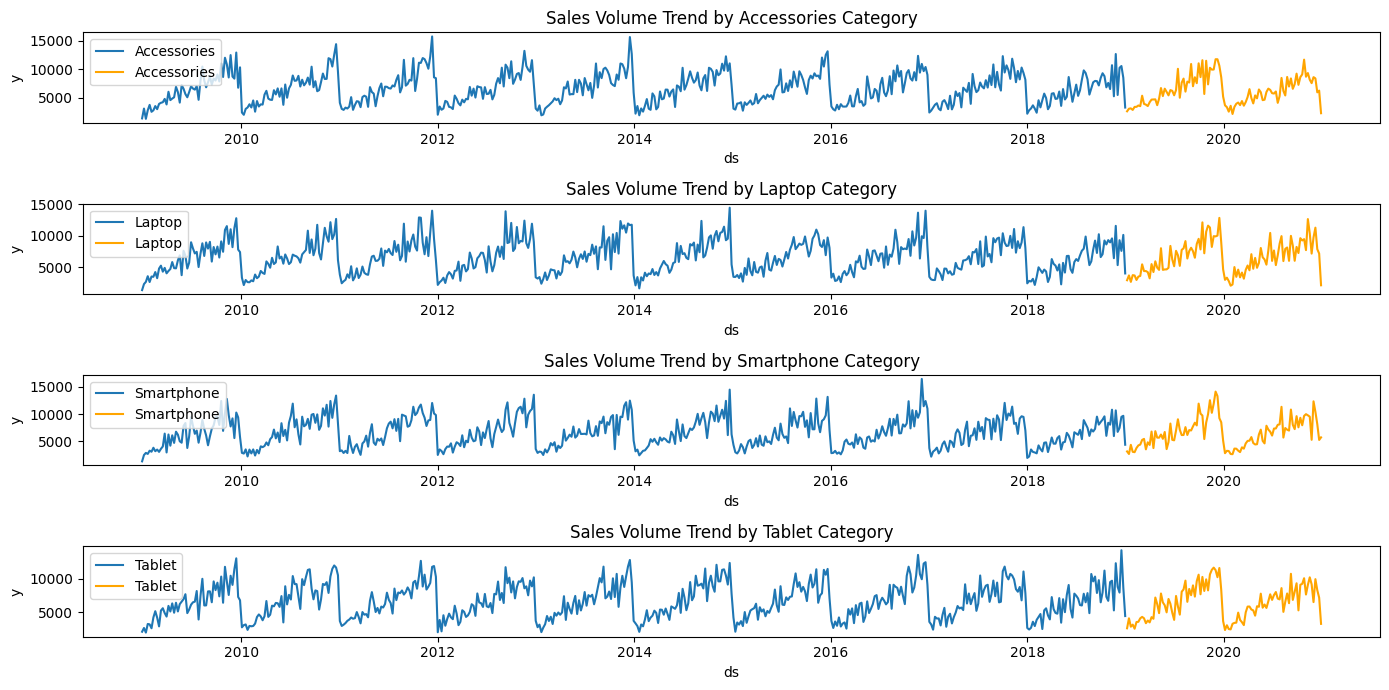

In [6]:
plt.figure(figsize=(14, 7))

for i in range(4):
    category = sales_by_week_category['Category'].unique()[i]
    
    plt.subplot(4, 1, i+1)
    plt.plot(train_data_week[category]['ds'], train_data_week[category]['y'], label=category)
    plt.plot(test_data_week[category]['ds'], test_data_week[category]['y'], label=category, color = 'orange')
    plt.title(f"Sales Volume Trend by {category} Category")
    plt.xlabel('ds')
    plt.ylabel('y')
    plt.legend()
    plt.tight_layout()
plt.show()

In [7]:
prophet_weekly_model = dict()

for category in sales_by_week_category['Category'].unique():
    model = Prophet()
    model.fit(train_data_week[category])
    prophet_weekly_model[category] = model

20:56:44 - cmdstanpy - INFO - Chain [1] start processing
20:56:46 - cmdstanpy - INFO - Chain [1] done processing
20:56:49 - cmdstanpy - INFO - Chain [1] start processing
20:56:50 - cmdstanpy - INFO - Chain [1] done processing
20:56:53 - cmdstanpy - INFO - Chain [1] start processing
20:56:54 - cmdstanpy - INFO - Chain [1] done processing
20:56:56 - cmdstanpy - INFO - Chain [1] start processing
20:56:56 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
prophet_weekly_model

{'Accessories': <prophet.forecaster.Prophet at 0x289d6e45890>,
 'Laptop': <prophet.forecaster.Prophet at 0x289d4a19310>,
 'Smartphone': <prophet.forecaster.Prophet at 0x289d6e245d0>,
 'Tablet': <prophet.forecaster.Prophet at 0x289d6f2b650>}

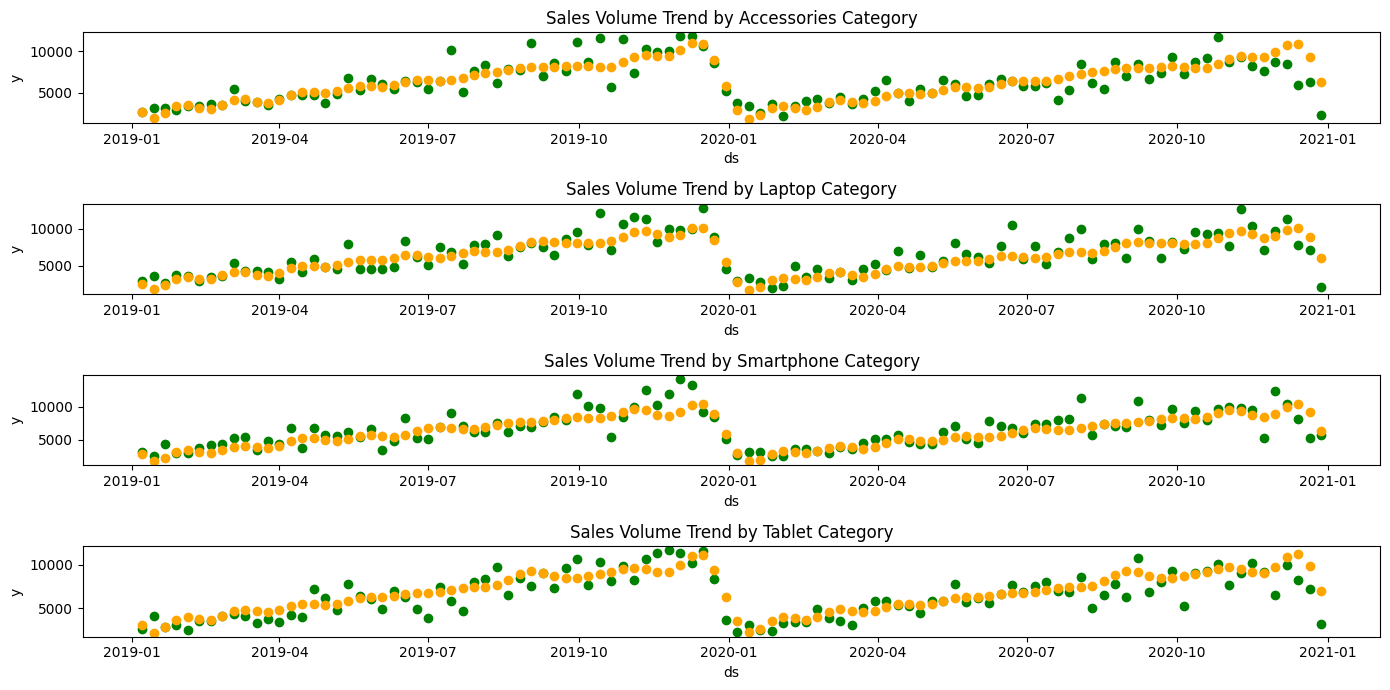

In [9]:
prophet_week_forecast = dict()

fig, ax = plt.subplots(4, 1, figsize=(14, 7))

for i in range(4):
    category = sales_by_week_category['Category'].unique()[i]
    
    prophet_week_forecast[category] = prophet_weekly_model[category].predict(test_data_week[category])
    
    ax[i].scatter(test_data_week[category]['ds'], test_data_week[category]['y'], label='Actual', color = 'green')
    ax[i].scatter(prophet_week_forecast[category]['ds'], prophet_week_forecast[category]['yhat'], label='Predicted', color = 'orange') 
    ax[i].set_title(f"Sales Volume Trend by {category} Category")
    ax[i].set_xlabel('ds')
    ax[i].set_ylabel('y')
    plt.tight_layout()
plt.show()
    

In [10]:
mae, mape, rmse = 0,0,0
for category in sales_by_week_category['Category'].unique():
    mae += mean_absolute_error(test_data_week[category]['y'], prophet_week_forecast[category]['yhat'])
    mape += mean_absolute_percentage_error(test_data_week[category]['y'], prophet_week_forecast[category]['yhat'])
    rmse += root_mean_squared_error(test_data_week[category]['y'], prophet_week_forecast[category]['yhat'])
    
mae /= 4
mape /= 4
rmse /= 4

print(f"MAE: {round(mae, 2)}")
print(f"MAPE: {round(mape * 100, 2)} %")
print(f"RMSE: {round(rmse, 2)}")

MAE: 1087.98
MAPE: 18.28 %
RMSE: 1427.93


## Forecasting and Evaulating Monthly using Prophet Model

We will be moving onto monthly forecasting for each of the product categories. We're going into monthly forecasting because, with monthly forecasts, we can easily aggregate sales, and the flunctuations that occur with weekly and daily data are lesser when aggregated monthly.

In [11]:
sales_by_month_category = date_category.copy()

sales_by_month_category['Date'] = sales_by_month_category['Date'].astype('datetime64[ns]')

sales_by_month_category['Date'] = sales_by_month_category['Date'].dt.to_period('M')

sales_by_month_category = sales_by_month_category.groupby(['Date', 'Category']).sum()['Sales_Volume'].reset_index()


sales_by_month_category['Date'] = sales_by_month_category['Date'].dt.to_timestamp()

sales_by_month_category

,Date,Category,Sales_Volume
0,2009-01-01,Accessories,11762
1,2009-01-01,Laptop,11989
2,2009-01-01,Smartphone,12192
3,2009-01-01,Tablet,12491
4,2009-02-01,Accessories,12086
...,...,...,...
571,2020-11-01,Tablet,38059
572,2020-12-01,Accessories,30717
573,2020-12-01,Laptop,37869
574,2020-12-01,Smartphone,40987


In [12]:
train_data_month = {}
test_data_month = {}

for category in sales_by_month_category['Category'].unique():
    category_data_monthly =sales_by_month_category[sales_by_month_category['Category'] == category][['Date', 'Sales_Volume']]
    
    category_data_monthly = category_data_monthly.rename(columns={'Date': 'ds', 'Sales_Volume': 'y'})
    
    train_data_month[category] = category_data_monthly[category_data_monthly['ds'].dt.year < 2019]
    test_data_month[category] = category_data_monthly[category_data_monthly['ds'].dt.year >= 2019]

In [13]:
prophet_monthly_model = dict()

for category in sales_by_month_category['Category'].unique():
    model = Prophet()
    model.fit(train_data_month[category])
    prophet_monthly_model[category] = model

20:57:28 - cmdstanpy - INFO - Chain [1] start processing
20:57:29 - cmdstanpy - INFO - Chain [1] done processing
20:57:31 - cmdstanpy - INFO - Chain [1] start processing
20:57:32 - cmdstanpy - INFO - Chain [1] done processing
20:57:33 - cmdstanpy - INFO - Chain [1] start processing
20:57:34 - cmdstanpy - INFO - Chain [1] done processing
20:57:35 - cmdstanpy - INFO - Chain [1] start processing
20:57:35 - cmdstanpy - INFO - Chain [1] done processing


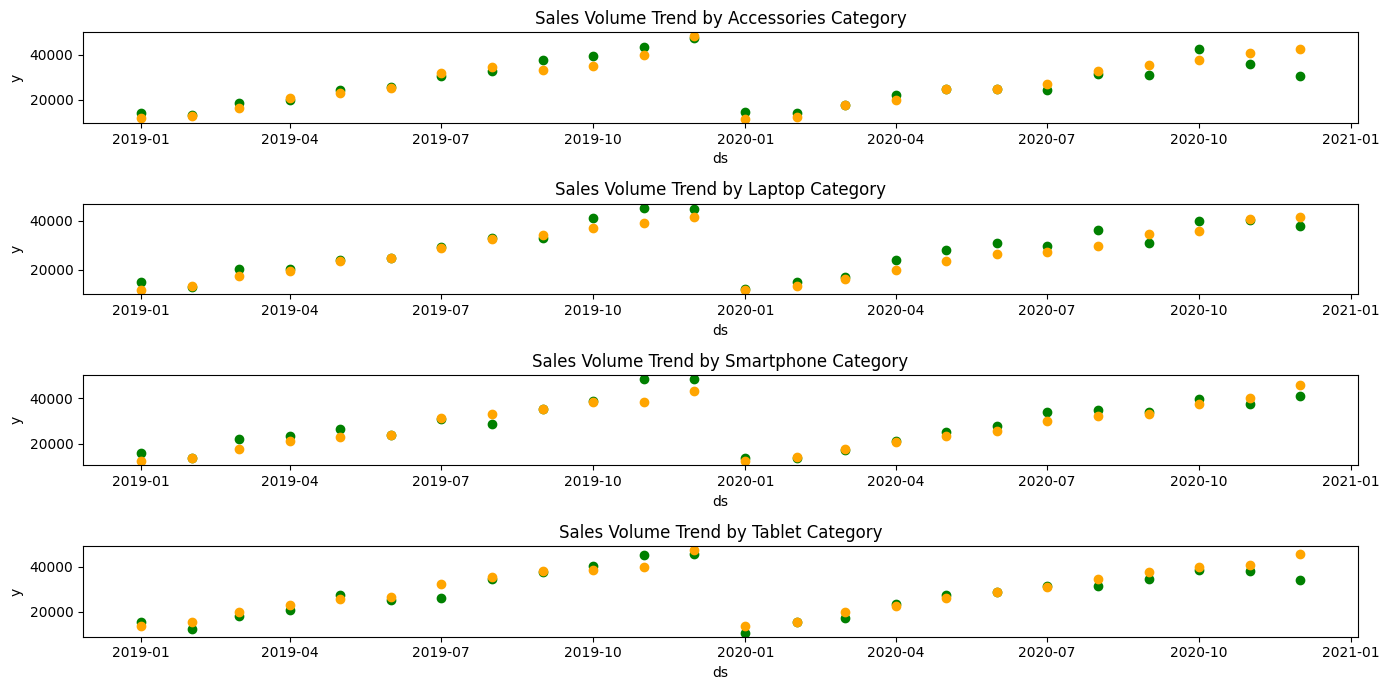

In [14]:
prophet_month_forecast = dict()

fig, ax = plt.subplots(4, 1, figsize=(14, 7))

for i in range(4):
    category = sales_by_month_category['Category'].unique()[i]
    
    prophet_month_forecast[category] = prophet_monthly_model[category].predict(test_data_month[category])
    
    ax[i].scatter(test_data_month[category]['ds'], test_data_month[category]['y'], label='Actual', color = 'green')
    ax[i].scatter(prophet_month_forecast[category]['ds'], prophet_month_forecast[category]['yhat'], label='Predicted', color = 'orange') 
    ax[i].set_title(f"Sales Volume Trend by {category} Category")
    ax[i].set_xlabel('ds')
    ax[i].set_ylabel('y')
    plt.tight_layout()
plt.show()
    

In [15]:
mae, mape, rmse = 0,0,0
for category in sales_by_month_category['Category'].unique():
    mae += mean_absolute_error(test_data_month[category]['y'], prophet_month_forecast[category]['yhat'])
    mape += mean_absolute_percentage_error(test_data_month[category]['y'], prophet_month_forecast[category]['yhat'])
    rmse += root_mean_squared_error(test_data_month[category]['y'], prophet_month_forecast[category]['yhat'])
    
mae /= 4
mape /= 4
rmse /= 4

print(f"MAE: {round(mae, 2)}")
print(f"MAPE: {round(mape * 100, 2)} %")
print(f"RMSE: {round(rmse, 2)}")

MAE: 2487.01
MAPE: 9.0 %
RMSE: 3354.73


In [ ]:
import pickle


In [18]:
for category in sales_by_month_category['Category'].unique():
    with open(f'{category}_model.pkl', 'wb') as file:
        pickle.dump((prophet_monthly_model[category], train_data_month[category].columns), file)

## Forecasting and Evaluating weekly with ARIMA model

ARIMA stands for AutoRegressive Integrated Moving Average. 

Before one can build a model on ARIMA, it's necessary to check for stationarity in the dataset, as this is a requirement for using ARIMA. Stationarity here means that the statistical properties like mean and variance of the dataset do not change overtime.

To do this stationarity test, the Augmented Dickey-Fuller test will be used. We begin by defining a function to help us do this.

## Forecasting and Evaluating monthly with ARIMA model

Here we will attempt to make monthly forecasts to see if the model gets better.

## Compare  Performance of These Models on Weekly and Monthly Basis

## Multivariate Forecasting